# Analytical uncertainty propagation

This notebook allows to calculate an analytical approximated error propagation of the hierarchical glSNe analysis. 

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib configs
from pylab import rc
rc('axes', linewidth=2)
rc('xtick',labelsize=15)
rc('ytick',labelsize=15)
#rc('text', usetex=True)



In [9]:
# =============================
# MST related error propagation
# =============================

def sigma_lambda_lens(sigma_lambda_int, sigma_kappa_ext):
    """
    Total relative uncertainty in the MST per individual lens
    
    :param sigma_lambda_int: relative scatter of the internal MST per lens
    :param sigma_kappa_ext: relative external convergence uncertainty per lens
    
    """
    return np.sqrt(sigma_lambda_int**2 + sigma_kappa_ext**2)

def sigma_mu_lens(sigma_m_app, sigma_mu_macro, sigma_m_std_eff, sigma_m_ml_eff, num_images=4):
    """
    relative magnification uncertainty per lens
    
    :param sigma_m_app: intrinsic scatter in the SNe apparent magnitude
    :param sigma_mu_macro: relative macro model magnification uncertainty (per image)
    :param sigma_F_eff: effective relative magnification uncertainties from flux measurement and unresolved mili- and micro-lensing (per image)
    :param num_images: number of multiple images per glSNe
    
    """
    sigma_F_app = sigma_m_app * 1.086  # change from logarithmic magnitude units to relative linear units
    sigma_F_std_eff = sigma_m_std_eff * 1.086
    sigma_F_ml_eff = sigma_m_ml_eff * 1.086
    return np.sqrt(sigma_F_app**2 + 1 / (1 / (sigma_mu_macro**2 + sigma_F_std_eff**2) + (num_images - 1) / (sigma_mu_macro**2 + sigma_F_ml_eff**2)))


def sigma_lambda_int_mean(sigma_m_p_mean, sigma_mu_lens, num_lens, sigma_lum_dist=0):
    """
    ucertainty in the mean of the MSR
    
    :param sigma_m_p_mean: uncertainty in the mean apparent magnitude of the SNe sample
    :param sigma_mu_lens: relative magnification uncertainty per lens
    :param num_lens: number of glSNe
    :param sigma_lum_dist: relative luminosity distance uncertainty between apparent magnitude measurement and strong lensing sources
    
    """
    return 1/2 * np.sqrt(sigma_m_p_mean**2 + 1/num_lens * sigma_mu_lens**2 + sigma_lum_dist**2)



In [10]:
# ======================================
# fixed population MST error propagation
# ======================================

def sigma_H0_no_mst(sigma_ddt_model, sigma_lambda_lens, num_lens, sigma_ang_dist=0):
    """
    uncertainty for fixed MST population
    
    :param sigma_ddt_model: relative time-delay distance uncertainty per len for given model
    :param sigma_lambda_lens: uncertainty in the MST per lens (internal and external combined)
    :param num_lens: number of glSNe
    :param sigma_ang_dist: relative angular diameter distance uncertainty of the time-delay distances relative to z=0
    """
    return np.sqrt(1 / num_lens * (sigma_ddt_model**2 + sigma_lambda_lens**2) + sigma_ang_dist**2)

# =================
# total uncertainty
# =================

def sigma_H0_combined(sigma_H0_no_mst, sigma_lambda_int_mean):
    """
    total uncertainty
    
    :param sigma_H0_no_mst: relative H0 uncertainty at fixed lambda_mean
    :param sigma_lambda_int_mean: uncertainty in the population mean of lambda
    
    """
    return np.sqrt(sigma_H0_no_mst**2 + sigma_lambda_int_mean**2)  # TODO: subtract uncertainty of population relative to sample


def sigma_H0_scenario(num_lens, num_images, sigma_ddt_model, sigma_mu_macro, sigma_m_std_eff, sigma_m_ml_eff, sigma_m_app, sigma_m_p_mean, 
                      sigma_lambda_int, sigma_kappa_ext, sigma_ang_dist, sigma_lum_dist, no_mst=False):
    """
    combined uncertainties given a forecast scenario
    
    :param num_lens: number of glSNe
    :param num_images: number of multiple images per glSNe
    :param sigma_ddt_model: relative time-delay distance uncertainty per len for given model
    :param sigma_mu_macro: relative macro model magnification uncertainty (per image)
    :param sigma_m_std_eff: effective relative magnification uncertainties from flux measurement and unresolved mili- and micro-lensing (per image)
     for standardizable image (1 per lens)
    :param sigma_m_ml_eff: effective relative magnification uncertainties from flux measurement and unresolved mili- and micro-lensing (per image)
     for non-standardizable image (other images than the standardizable one)
    :param sigma_m_app: intrinsic scatter in the SNe apparent magnitude
    :param sigma_m_p_mean: uncertainty in the mean apparent magnitude of the SNe sample
    :param sigma_lambda_int: relative scatter of the internal MST per lens
    :param sigma_kappa_ext: relative external convergence uncertainty per lens
    :param sigma_ang_dist: relative angular diameter distance uncertainty of the time-delay distances relative to z=0
    :param sigma_lum_dist: relative luminosity distance uncertainty between apparent magnitude measurement and strong lensing sources
    :param no_mst: boolean; if True, ignores error in the MST population mean
    """
    sigma_lambda_lens_ = sigma_lambda_lens(sigma_lambda_int, sigma_kappa_ext)
    sigma_mu_lens_ = sigma_mu_lens(sigma_m_app, sigma_mu_macro, sigma_m_std_eff, sigma_m_ml_eff, num_images)
    if no_mst:
        sigma_lambda_int_mean_ = 0
        sigma_lambda_int_mean_corr = 0
    else:
        sigma_lambda_int_mean_ = sigma_lambda_int_mean(sigma_m_p_mean, sigma_mu_lens_, num_lens, sigma_lum_dist)
        sigma_lambda_int_mean_corr = sigma_lambda_int_mean_
    sigma_H0_no_mst_ = sigma_H0_no_mst(sigma_ddt_model, sigma_lambda_lens_, num_lens, sigma_ang_dist)
    
    sigma_H0_ = sigma_H0_combined(sigma_H0_no_mst_, sigma_lambda_int_mean_corr)
    return sigma_H0_, sigma_lambda_int_mean_


In [35]:

kwargs_joint = {'num_lens': 144, 
                'num_images': 3,
                'sigma_ddt_model': 0.04,
                'sigma_mu_macro': 0.05,
                'sigma_m_ml_eff': 1.0,
                'sigma_m_app': 0.1,
                'sigma_lambda_int': 0.03,
                'sigma_kappa_ext': 0.025,
                
               }

kwargs_pantheon = {'sigma_m_p_mean': 0.008,
                   'sigma_ang_dist': 0.004, 
                   'sigma_lum_dist': 0.015
                  }

kwargs_future = {'sigma_m_p_mean': 0.006,
                   'sigma_ang_dist': 0, 
                   'sigma_lum_dist': 0
                  }


kwargs_patheon_no_mst = {**kwargs_joint, **kwargs_pantheon, 'sigma_m_std_eff': 0.0, 'no_mst': True}
kwargs_patheon_00 = {**kwargs_joint, **kwargs_pantheon, 'sigma_m_std_eff': 0.0}
kwargs_patheon_03 = {**kwargs_joint, **kwargs_pantheon, 'sigma_m_std_eff': 0.2}
kwargs_patheon_10 = {**kwargs_joint, **kwargs_pantheon, 'sigma_m_std_eff': 1.0}

kwargs_future_no_mst = {**kwargs_joint, **kwargs_future, 'sigma_m_std_eff': 0.0, 'no_mst': True}
kwargs_future_00 = {**kwargs_joint, **kwargs_future, 'sigma_m_std_eff': 0.0}
kwargs_future_03 = {**kwargs_joint, **kwargs_future, 'sigma_m_std_eff': 0.3}
kwargs_future_10 = {**kwargs_joint, **kwargs_future, 'sigma_m_std_eff': 1.0}

print('Pantheon no MST', sigma_H0_scenario(**kwargs_patheon_no_mst))
print('Pantheon 00', sigma_H0_scenario(**kwargs_patheon_00))
print('Pantheon 03', sigma_H0_scenario(**kwargs_patheon_03))
print('Pantheon 10', sigma_H0_scenario(**kwargs_patheon_10))

print('Future no MST', sigma_H0_scenario(**kwargs_future_no_mst))
print('Future 00', sigma_H0_scenario(**kwargs_future_00))
print('Future 03', sigma_H0_scenario(**kwargs_future_03))
print('Future 10', sigma_H0_scenario(**kwargs_future_10))


Pantheon no MST (0.006140145673262882, 0)
Pantheon 00 (0.011608144016722378, 0.00985127497454409)
Pantheon 03 (0.014490765172216535, 0.013125581373311997)
Pantheon 10 (0.028537599872474933, 0.027869216307470728)
Future no MST (0.004658474953124562, 0)
Future 00 (0.0074497656012097145, 0.005813571933336565)
Future 03 (0.014508805192086636, 0.013740598211614777)
Future 10 (0.02711355023750083, 0.02671035787091952)


In [41]:
# plot forecast figure with increasing number of glSNe for Pantheon and Future scenario


num_plot = 300

num_list = []

pantheon_h0_00_list = []
future_h0_00_list = []

pantheon_h0_03_list = []
future_h0_03_list = []

pantheon_h0_10_list = []
future_h0_10_list = []




for n in range(1, num_plot):
    num_list.append(n)
    kwargs_patheon_plot = {**kwargs_joint, **kwargs_pantheon, 'sigma_m_std_eff': 0.0, 'num_lens': n}
    h0, _ = sigma_H0_scenario(**kwargs_patheon_plot)
    pantheon_h0_00_list.append(h0)
    
    kwargs_patheon_plot = {**kwargs_joint, **kwargs_pantheon, 'sigma_m_std_eff': 0.2, 'num_lens': n}
    h0, _ = sigma_H0_scenario(**kwargs_patheon_plot)
    pantheon_h0_03_list.append(h0)
    
    kwargs_patheon_plot = {**kwargs_joint, **kwargs_pantheon, 'sigma_m_std_eff': 1.0, 'num_lens': n}
    h0, _ = sigma_H0_scenario(**kwargs_patheon_plot)
    pantheon_h0_10_list.append(h0)
    
    kwargs_future_plot = {**kwargs_joint, **kwargs_future, 'sigma_m_std_eff': 0.0, 'num_lens': n}
    h0, _ = sigma_H0_scenario(**kwargs_future_plot)
    future_h0_00_list.append(h0)
    
    kwargs_future_plot = {**kwargs_joint, **kwargs_future, 'sigma_m_std_eff': 0.2, 'num_lens': n}
    h0, _ = sigma_H0_scenario(**kwargs_future_plot)
    future_h0_03_list.append(h0)
    
    kwargs_future_plot = {**kwargs_joint, **kwargs_future, 'sigma_m_std_eff': 1.0, 'num_lens': n}
    h0, _ = sigma_H0_scenario(**kwargs_future_plot)
    future_h0_10_list.append(h0)
    
    





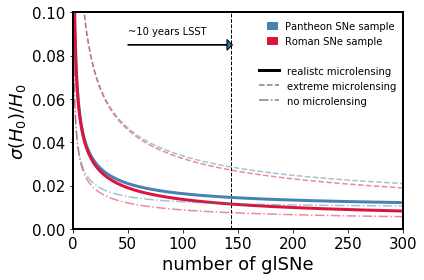

In [42]:


save_plot = False

color_pantheon = 'steelblue'
color_future = 'crimson'
    
plt.plot(num_list, pantheon_h0_03_list, color_pantheon, label='Pantheon SNe sample', linewidth=3)
plt.plot(num_list, future_h0_03_list, color_future, label='Roman SNe sample', linewidth=3)

plt.plot(num_list, pantheon_h0_10_list, color_pantheon, linestyle='--', alpha=0.5)
plt.plot(num_list, future_h0_10_list, color_future, linestyle='--', alpha=0.5)

plt.plot(num_list, pantheon_h0_00_list, color_pantheon, linestyle='-.', alpha=0.5)
plt.plot(num_list, future_h0_00_list, color_future, linestyle='-.', alpha=0.5)


plt.ylim(0, 0.1)
plt.xlim(0, 300)

line1, = plt.plot(-10, 10, 'k-', linewidth=3, label='realistc microlensing')
line2, = plt.plot(-10, 10, 'k--', alpha=0.5, label='extreme microlensing')
line3, = plt.plot(-10, 10, 'k-.', alpha=0.5, label='no microlensing')




import matplotlib.patches as mpatches
patch_1 = mpatches.Patch(color=color_pantheon, label='Pantheon SNe sample', alpha=1)
patch_2 = mpatches.Patch(color=color_future, label='Roman SNe sample', alpha=1)



# Create a legend for the first line.
first_legend = plt.legend(handles=[line1, line2, line3], loc=(0.55, 0.55), frameon=False)

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

# Create another legend for the second line.
plt.legend(handles=[patch_1, patch_2], fontsize=10, handlelength=1, loc=1, frameon=False)

plt.vlines(x=144, ymin=0, ymax=1, color='k', linestyle='--', linewidth=1)
plt.arrow(x=50, y=0.085, dx=90, dy=0, width=0.0001, head_width=0.005, head_length=5)
plt.text(50, 0.09, '~10 years LSST')

#plt.hlines(y=0.01, xmin=1, xmax=num_plot, color='k', linestyle='--', linewidth=1)
#plt.text(2, 0.011, '1%')
plt.xlabel(r'number of glSNe', fontsize=18)
plt.ylabel(r'$\sigma(H_0) / H_0 $', fontsize=18)


plt.tight_layout()
    
if save_plot:
    plt.savefig('/Users/sibirrer/Science/Publications/glSNe/Plots/number_forecast.pdf', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='pdf',
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)

plt.show()